# Landscape Setup

In this demo, we will generate a landscape on a ring Euclidean geometry and optimize it over a continuous space.

## Loading Libraries and Paths

In [96]:
# Fix PROJ path ---------------------------------------------------------------
import os; os.environ['PROJ_LIB']='/path/to/env/share/proj'
# Load libraries --------------------------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt
import MGSurvE as srv
%matplotlib inline
# Setup data path and ID ------------------------------------------------------
(ID, OUT_PTH) = ('quickstart', './out/')
srv.makeFolder(OUT_PTH)

## Dwells, Traps and Mosquito Movement

The two main elements in our MGSurvE landscapes are traps and dwells. In this example, we will lay down mosquito habitats in a ring with given inner and outer radii, then optimize the position of two different types of traps simultaneously.

### Habitats

To lay down our habitats in a Euclidean space we need to generate a pandas dataframe with three columns: 
* `'x'`: list of point coordinates along our first axis
* `'y'`: list of point coordinates along our second axis
* `'t'`: dwell type (all set to `0` for this example)

In [97]:
PTS_NUM = 100
RADII = (75, 100)
# Generate pointset -----------------------------------------------------------
xy = srv.ptsDonut(PTS_NUM, RADII).T
# Re-shape pointset into dataframe --------------------------------------------
points = pd.DataFrame({
    'x': xy[0], 'y': xy[1], 
    't': [0]*len(xy[0])
})

### Traps

For our traps we also need a pandas dataframe, this time containing the following columns:
* `'x'`: list of point coordinates along our first axis (for continuous optimization)
* `'y'`: list of point coordinates along our second axis (for continuous optimization)
* `'sid'`: id of the dwell in which the trap is located (for discrete optimization)
* `'t'`: trap type kernel id (as set in trap kernel dictionary)
* `'f'`: boolean to mark a trap as immovable (`False` or `0` leaves the trap as optimizable)

In [98]:
nullTraps = [0, 0, 0, 0]
traps = pd.DataFrame({
    'x': nullTraps, 'y': nullTraps, 'sid': nullTraps,
    't': [0, 0, 1, 1], 
    'f': [0, 0, 0, 0]
})

Additionally, we need to define the attractiveness profile of our trap types in a dictionary in which the keys must match the types used in the `'t'` column of our dataframe. 

In [99]:
tKer = {
    0: {'kernel': srv.exponentialDecay, 'params': {'A': .75, 'b': .100}},
    1: {'kernel': srv.exponentialDecay, 'params': {'A': .50, 'b': .125}}
}

### Mosquito Movement

We will go into more details on how to setup the mosquito movement in our model, but for now let's select just a predefined "short-distance"  flyer (~15 m conditional upon movement).

In [100]:
mKer = {
    'params': srv.MEDIUM_MOV_EXP_PARAMS, 
    'zeroInflation': .25
} 

## Landscape

We are now ready to setup the main structure in our worfklow, the landscape object. We do this by passing the points, mosquito movement kernel, traps, and traps kernels parameters.

In [101]:
lnd = srv.Landscape(
    points, 
    kernelParams=mKer,
    traps=traps, trapsKernels=tKer
)

Inspecting the traps kernels is simple:

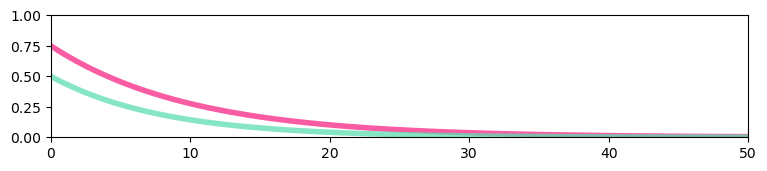

In [102]:
(fig, ax) = plt.subplots(1, 1, figsize=(9, 3), sharey=False)
(fig, ax) = srv.plotTrapsKernels(fig, ax, lnd, distRange=(0, 50), aspect=.175)
fig.savefig(
    os.path.join(OUT_PTH, '{}-KER.png'.format(ID)), 
    facecolor='w', bbox_inches='tight', pad_inches=0.1, dpi=150
)

As well as taking a look at our landscape:

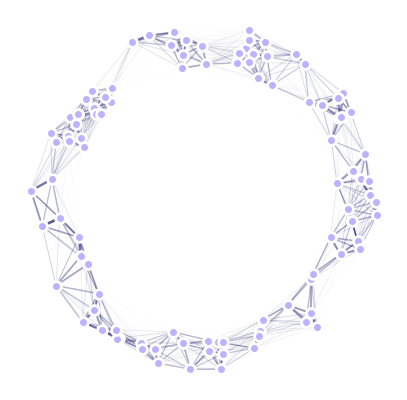

In [103]:
(fig, ax) = plt.subplots(1, 1, figsize=(5, 5), sharey=False)
lnd.plotSites(fig, ax, size=50)
lnd.plotMaskedMigrationNetwork(fig, ax, alphaMin=.6, lineWidth=25)
srv.plotClean(fig, ax, frame=False)
fig.savefig(
    os.path.join(OUT_PTH, '{}_CLN.png'.format(ID)), 
    facecolor='w', bbox_inches='tight', pad_inches=0.1, dpi=150
)

## Quick Optimization

And now we are good to go. We are going to run a pretty basic continuous optimization through a genetic algorithm with the default settings provided by MGSurvE.

In [104]:
GENS = 500
(lnd, logbook) = srv.optimizeTrapsGA(
    lnd, generations=GENS, verbose=False,
    pop_size='auto', mating_params='auto', 
    mutation_params='auto', selection_params='auto',
)
# Export optimized landscape and log to disk ----------------------------------
srv.exportLog(logbook, OUT_PTH, '{}_LOG'.format(ID))
srv.dumpLandscape(lnd, OUT_PTH, '{}_LND'.format(ID), fExt='pkl')

/Users/sanchez.hmsc/miniconda3/envs/MGSurvE/lib/python3.10/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/sanchez.hmsc/miniconda3/envs/MGSurvE/lib/python3.10/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Finally, we will export the resulting positions of our traps over the landscape!

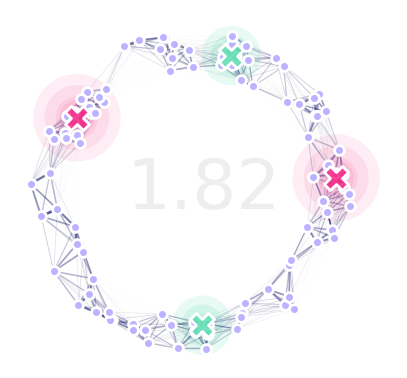

In [105]:
(fig, ax) = plt.subplots(1, 1, figsize=(5, 5), sharey=False)
lnd.plotSites(fig, ax, size=50)
lnd.plotMaskedMigrationNetwork(fig, ax, alphaMin=.6, lineWidth=25)
lnd.plotTraps(fig, ax)
srv.plotClean(fig, ax, frame=False)
srv.plotFitness(fig, ax, min(logbook['min']), fontSize=50)
fig.savefig(
    os.path.join(OUT_PTH, '{}_TRP.png'.format(ID)), 
    facecolor='w', bbox_inches='tight', pad_inches=0.1, dpi=150
)